In [1]:
import numpy as np
import math
import torch
from torch import nn

import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.GeNVI_method import GeNVariationalInference, GeNetEns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [35]:
def logmvnpdf(theta, mu, v=1.):
    """
    Evaluation of log proba with density N(0,v*I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    dim = theta.shape[1]
    S = v*torch.ones(dim).type_as(theta).to(device)
    n_x = theta.shape[0]

    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta-mu.view(1, dim))**2).view(n_x, dim)
    const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    return -0.5*(H*d).sum(2).squeeze()-const

# Target density #

In [80]:
def _logtarget(theta, device=device):
    """
    Evaluation of log proba with density N(0,I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    
    
    
    dim = theta.shape[1]
    S = torch.Tensor([.5,.1]).to(device)
    mu = torch.Tensor([0., 0.]).to(device)
    n_x = theta.shape[0]
    
    MM=torch.Tensor([[1.,0.],
                [1., -1.]])
    theta=torch.matmul(MM.view(1,2,2),torch.pow(theta, torch.Tensor([3.,1.])).view(n_x,2,1)).squeeze(0)
    #theta=torch.pow(theta, torch.Tensor([1.,.3]))
    #print(theta.shape)

    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta.view(n_x,dim)-mu.view(1, dim))**2).view(n_x, dim)
    #const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    v=torch.pow(H*d, torch.Tensor([4., 1.]))
    return -0.5*(v).sum(2).squeeze()


theta=np.pi/3.
def M(theta):
    M=torch.Tensor([[np.cos(theta),-np.sin(theta)],
                [np.sin(theta), np.cos(theta)]])
    return M



def llogtarget(theta, device=device):
    """
    Evaluation of log proba with density N(0,I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    
    
    
    dim = theta.shape[1]
    S = torch.Tensor([.5,.1]).to(device)
    mu = torch.Tensor([0., 0.]).to(device)
    n_x = theta.shape[0]
    
    MM=torch.Tensor([[.5,0.],
                [.5, -1.]])
    theta=torch.matmul(MM.view(1,2,2),torch.pow(theta, torch.Tensor([2.,1.])).view(n_x,2,1)).squeeze(0)
    #theta=torch.pow(theta, torch.Tensor([1.,.3]))
    #print(theta.shape)

    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta.view(n_x,dim)-mu.view(1, dim))**2).view(n_x, dim)
    #const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    v=torch.pow(H*d, torch.Tensor([4., 1.]))
    return -0.5*(v).sum(2).squeeze()

def logprobflatnormal(theta, device=device):
    """
    Evaluation of log proba with density N(0,I_n)

    Parameters:
    x (Tensor): Data tensor of size NxD

    Returns:
    logproba (Tensor): size N, vector of log probabilities
    """
    
    
    
    dim = theta.shape[1]
    S = torch.Tensor([1.,.1]).to(device)
    mu = torch.Tensor([0., 0.]).to(device)
    n_x = theta.shape[0]
    
  
    H = S.view(dim, 1, 1).inverse().view(1, 1, dim)
    d = ((theta.view(n_x,dim)-mu.view(1, dim))**2).view(n_x, dim)
    #const = 0.5*S.log().sum()+0.5*dim*torch.tensor(2*math.pi).log()
    v=torch.pow(H*d, torch.Tensor([1., 1.]))
    return -0.5*(v).sum(2).pow(4).squeeze()

def logtarget_(x):
    n=x.shape[0]
    return -(-d.log_prob(torch.matmul(M(theta).view(1,2,2),x.view(n,2,1)).squeeze(0-1))).pow(4.)

def logtarget__(x):
    n=x.shape[0]
    a=-(-d.log_prob(torch.matmul(M(theta).view(1,2,2),x.view(n,2,1)).squeeze(0-1))).pow(4.)
    b=-(-dd.log_prob(torch.matmul(M(-theta).view(1,2,2),x.view(n,2,1)).squeeze(0-1))).pow(2.)
    return a+b- torch.tensor(2.).log()

def neg_log_p_Funnel(x):
    n=x.shape[0]
    funnel_dim=x.shape[1]-1
    [s,y]=x.split([1,funnel_dim], dim=1)
    scale=logmvnpdf(s.view(-1,1),  torch.zeros(1).to(device),3.)
    funnel=torch.Tensor(n).to(device)
    for i in range(n):
        funnel[i]=logmvnpdf(y[i].view(1,funnel_dim), torch.zeros(funnel_dim).to(device),s[i].exp())
    return scale + funnel


In [81]:
logtarget= lambda theta: neg_log_p_Funnel(theta)
X=torch.Tensor([1.,0.]).unsqueeze(0).to(device)
#X.shape
logtarget(X)

tensor([-3.0538], device='cuda:0')

In [95]:
%matplotlib notebook


x=y=torch.arange(-10.,10.,0.1).to(device)
grid_x, grid_y = torch.meshgrid(x, y)
p=torch.Tensor(grid_x.shape).to(device)

for i in range(p.shape[0]):
    for j in range(p.shape[1]):
        x=torch.Tensor([grid_x[i,j],grid_y[i,j]]).to(device).unsqueeze(0)
        p[i,j]=logtarget(x).squeeze()



(-10.0, 9.899999618530273, -10.0, 9.899999618530273)

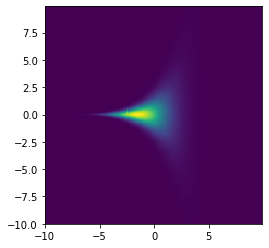

In [104]:
%matplotlib inline
plt.pcolormesh(grid_x.cpu().numpy(),grid_y.cpu().numpy(),p.exp().cpu().numpy())
plt.axis('scaled')


# AE-Variational Distribution #

In [112]:
activation = nn.Tanh()#nn.ReLU()
init_b = .001

GeN = GeNetEns(1, 2, 50, 2, activation, 0.1, init_b, device)

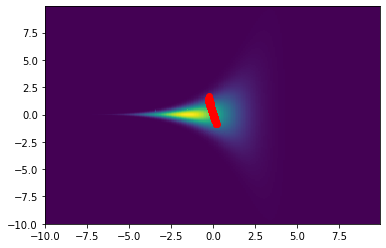

In [113]:
%matplotlib inline


Z=GeN(1000).cpu().detach()

plt.pcolormesh(grid_x.cpu().numpy(),grid_y.cpu().numpy(),p.exp().cpu().numpy())
plt.scatter(Z[:,0],Z[:,1],color='red') 


In [114]:
%matplotlib inline
from tempfile import TemporaryDirectory

#sample, = ax.scatter([],[],color='red',alpha=0.07)
#fig.canvas.draw()

def show(GeN,n,alpha=0.07):
    """
    Z=GeN(n).detach().clone().cpu()
    plt.pcolormesh(grid_x.cpu().numpy(),grid_y.cpu().numpy(),p.exp().cpu().numpy())
    plt.scatter(Z[:,0],Z[:,1],color='red',alpha=alpha) 
    plt.draw()
    plt.show()
    """

with TemporaryDirectory() as temp_dir:
    optimizer = GeNVariationalInference(logtarget,
		                                    0, 100, 1000, 50, 100,
		                                    10000, .01, .000001, 50, .5,
		                                    device, True, temp_dir, save_best=True)
    best_epoch, scores=optimizer.run(GeN,show)
print(best_epoch)

Epoch [0/10000], Loss: 3.8002123832702637, Entropy -1.160025715827942, Learning Rate: 0.01
Epoch [1/10000], Loss: 2.7794737815856934, Entropy -0.022488383576273918, Learning Rate: 0.01
Epoch [2/10000], Loss: 1.8623032569885254, Entropy 0.9008231163024902, Learning Rate: 0.01
Epoch [3/10000], Loss: 1.2851101160049438, Entropy 1.665563941001892, Learning Rate: 0.01
Epoch [4/10000], Loss: 0.8844300508499146, Entropy 1.983054518699646, Learning Rate: 0.01
Epoch [5/10000], Loss: 0.7711801528930664, Entropy 2.2143373489379883, Learning Rate: 0.01
Epoch [6/10000], Loss: 0.4721097946166992, Entropy 2.437946319580078, Learning Rate: 0.01
Epoch [7/10000], Loss: 0.42429351806640625, Entropy 2.6589715480804443, Learning Rate: 0.01
Epoch [8/10000], Loss: 0.4398193359375, Entropy 2.822451114654541, Learning Rate: 0.01
Epoch [9/10000], Loss: 0.6647989749908447, Entropy 2.828190565109253, Learning Rate: 0.01
Epoch [10/10000], Loss: 0.43210458755493164, Entropy 2.9070887565612793, Learning Rate: 0.01
E

Epoch [91/10000], Loss: 0.16709399223327637, Entropy 3.058642625808716, Learning Rate: 0.01
Epoch [92/10000], Loss: -0.02940988540649414, Entropy 3.0595123767852783, Learning Rate: 0.01
Epoch [93/10000], Loss: 0.17891263961791992, Entropy 3.0190627574920654, Learning Rate: 0.01
Epoch [94/10000], Loss: 0.09353947639465332, Entropy 3.019692897796631, Learning Rate: 0.01
Epoch [95/10000], Loss: 0.10699915885925293, Entropy 3.1536519527435303, Learning Rate: 0.01
Epoch [96/10000], Loss: 0.06597328186035156, Entropy 3.0610992908477783, Learning Rate: 0.01
Epoch [97/10000], Loss: 0.16451549530029297, Entropy 2.9374961853027344, Learning Rate: 0.01
Epoch [98/10000], Loss: -0.09359955787658691, Entropy 3.216721534729004, Learning Rate: 0.01
Epoch [99/10000], Loss: 0.22965526580810547, Entropy 3.0560505390167236, Learning Rate: 0.01
Epoch [100/10000], Loss: 0.0057260990142822266, Entropy 3.068779945373535, Learning Rate: 0.01
Epoch [101/10000], Loss: -0.05747246742248535, Entropy 3.030131816864

Epoch [180/10000], Loss: -0.028887033462524414, Entropy 3.3078508377075195, Learning Rate: 0.005
Epoch [181/10000], Loss: -0.19475674629211426, Entropy 3.319941997528076, Learning Rate: 0.005
Epoch [182/10000], Loss: -0.17240285873413086, Entropy 3.421234607696533, Learning Rate: 0.005
Epoch [183/10000], Loss: -0.08543515205383301, Entropy 3.2773797512054443, Learning Rate: 0.005
Epoch [184/10000], Loss: 0.04679679870605469, Entropy 3.2339227199554443, Learning Rate: 0.005
Epoch [185/10000], Loss: -0.0778965950012207, Entropy 3.2919697761535645, Learning Rate: 0.005
Epoch [186/10000], Loss: -0.03227043151855469, Entropy 3.2867186069488525, Learning Rate: 0.005
Epoch [187/10000], Loss: -0.5854029655456543, Entropy 3.8386497497558594, Learning Rate: 0.005
Epoch [188/10000], Loss: -0.13529109954833984, Entropy 3.1890623569488525, Learning Rate: 0.005
Epoch [189/10000], Loss: -0.25386834144592285, Entropy 3.4939591884613037, Learning Rate: 0.005
Epoch [190/10000], Loss: -0.4053382873535156

Epoch [267/10000], Loss: 0.1513369083404541, Entropy 3.359860420227051, Learning Rate: 0.0025
Epoch [268/10000], Loss: -0.09238505363464355, Entropy 3.3263614177703857, Learning Rate: 0.0025
Epoch [269/10000], Loss: 0.04401397705078125, Entropy 3.389883279800415, Learning Rate: 0.0025
Epoch [270/10000], Loss: -0.23346328735351562, Entropy 3.5546786785125732, Learning Rate: 0.0025
Epoch [271/10000], Loss: -0.05436086654663086, Entropy 3.3552348613739014, Learning Rate: 0.0025
Epoch [272/10000], Loss: 0.30559611320495605, Entropy 3.108351469039917, Learning Rate: 0.0025
Epoch [273/10000], Loss: -0.1540987491607666, Entropy 3.4378926753997803, Learning Rate: 0.0025
Epoch [274/10000], Loss: -0.09760618209838867, Entropy 3.436155319213867, Learning Rate: 0.0025
Epoch [275/10000], Loss: -0.34666895866394043, Entropy 3.426147937774658, Learning Rate: 0.0025
Epoch [276/10000], Loss: -0.05256772041320801, Entropy 3.4473061561584473, Learning Rate: 0.0025
Epoch [277/10000], Loss: -0.184558868408

Epoch [353/10000], Loss: -0.1781923770904541, Entropy 3.508138656616211, Learning Rate: 0.000625
Epoch [354/10000], Loss: 0.05039238929748535, Entropy 3.51175594329834, Learning Rate: 0.000625
Epoch [355/10000], Loss: -0.10590815544128418, Entropy 3.262410879135132, Learning Rate: 0.000625
Epoch [356/10000], Loss: -0.040645599365234375, Entropy 3.292951822280884, Learning Rate: 0.000625
Epoch [357/10000], Loss: -0.36879825592041016, Entropy 3.545830011367798, Learning Rate: 0.000625
Epoch [358/10000], Loss: -0.46007680892944336, Entropy 3.7331607341766357, Learning Rate: 0.000625
Epoch [359/10000], Loss: -0.10863637924194336, Entropy 3.3502299785614014, Learning Rate: 0.000625
Epoch [360/10000], Loss: 0.06392025947570801, Entropy 3.426020383834839, Learning Rate: 0.000625
Epoch [361/10000], Loss: -0.20565557479858398, Entropy 3.464707612991333, Learning Rate: 0.000625
Epoch [362/10000], Loss: -0.0807962417602539, Entropy 3.4092366695404053, Learning Rate: 0.000625
Epoch [363/10000], Lo

Epoch [438/10000], Loss: 0.10653567314147949, Entropy 3.328752279281616, Learning Rate: 0.0003125
Epoch [439/10000], Loss: -0.06915044784545898, Entropy 3.344132661819458, Learning Rate: 0.0003125
Epoch [440/10000], Loss: -0.3985006809234619, Entropy 3.6347405910491943, Learning Rate: 0.0003125
Epoch [441/10000], Loss: -0.10743117332458496, Entropy 3.4911396503448486, Learning Rate: 0.0003125
Epoch [442/10000], Loss: -0.024227619171142578, Entropy 3.4568583965301514, Learning Rate: 0.0003125
Epoch [443/10000], Loss: -0.39621543884277344, Entropy 3.613828659057617, Learning Rate: 0.0003125
Epoch [444/10000], Loss: -0.11074185371398926, Entropy 3.4523696899414062, Learning Rate: 0.0003125
Epoch [445/10000], Loss: -0.3106396198272705, Entropy 3.636134624481201, Learning Rate: 0.0003125
Epoch [446/10000], Loss: -0.11641740798950195, Entropy 3.595700979232788, Learning Rate: 0.0003125
Epoch [447/10000], Loss: -0.05627012252807617, Entropy 3.2938930988311768, Learning Rate: 0.0003125
Epoch [

Epoch [522/10000], Loss: 0.04292869567871094, Entropy 3.4358181953430176, Learning Rate: 0.00015625
Epoch [523/10000], Loss: -0.44315457344055176, Entropy 3.6086037158966064, Learning Rate: 0.00015625
Epoch [524/10000], Loss: -0.14583849906921387, Entropy 3.3838798999786377, Learning Rate: 0.00015625
Epoch [525/10000], Loss: -0.21721124649047852, Entropy 3.541598320007324, Learning Rate: 0.00015625
Epoch [526/10000], Loss: 0.06096625328063965, Entropy 3.2973546981811523, Learning Rate: 0.00015625
Epoch [527/10000], Loss: -0.2816951274871826, Entropy 3.5816545486450195, Learning Rate: 0.00015625
Epoch [528/10000], Loss: 0.07921910285949707, Entropy 3.2425832748413086, Learning Rate: 0.00015625
Epoch [529/10000], Loss: 0.03360605239868164, Entropy 3.3986408710479736, Learning Rate: 0.00015625
Epoch [530/10000], Loss: -0.3213315010070801, Entropy 3.800285577774048, Learning Rate: 0.00015625
Epoch [531/10000], Loss: -0.21756410598754883, Entropy 3.518785238265991, Learning Rate: 0.00015625

Epoch [604/10000], Loss: 0.055109262466430664, Entropy 3.191469669342041, Learning Rate: 3.90625e-05
Epoch [605/10000], Loss: 0.09284114837646484, Entropy 3.270986795425415, Learning Rate: 3.90625e-05
Epoch [606/10000], Loss: -0.02722477912902832, Entropy 3.3812811374664307, Learning Rate: 3.90625e-05
Epoch [607/10000], Loss: 0.045679569244384766, Entropy 3.5302767753601074, Learning Rate: 3.90625e-05
Epoch [608/10000], Loss: -0.14137983322143555, Entropy 3.3035948276519775, Learning Rate: 3.90625e-05
Epoch [609/10000], Loss: 0.03450441360473633, Entropy 3.2418212890625, Learning Rate: 3.90625e-05
Epoch [610/10000], Loss: -0.1018519401550293, Entropy 3.361072540283203, Learning Rate: 3.90625e-05
Epoch [611/10000], Loss: -0.14777684211730957, Entropy 3.596694231033325, Learning Rate: 3.90625e-05
Epoch [612/10000], Loss: 0.05130910873413086, Entropy 3.461702823638916, Learning Rate: 3.90625e-05
Epoch [613/10000], Loss: 0.012271881103515625, Entropy 3.4383440017700195, Learning Rate: 3.90

Epoch [687/10000], Loss: -0.4308779239654541, Entropy 3.4697604179382324, Learning Rate: 1.953125e-05
Epoch [688/10000], Loss: -0.10796952247619629, Entropy 3.44905948638916, Learning Rate: 1.953125e-05
Epoch [689/10000], Loss: 0.11717104911804199, Entropy 3.2838103771209717, Learning Rate: 1.953125e-05
Epoch [690/10000], Loss: -0.32235288619995117, Entropy 3.5279362201690674, Learning Rate: 1.953125e-05
Epoch [691/10000], Loss: -0.12943482398986816, Entropy 3.455422878265381, Learning Rate: 1.953125e-05
Epoch [692/10000], Loss: 0.07426190376281738, Entropy 3.333414316177368, Learning Rate: 1.953125e-05
Epoch [693/10000], Loss: -0.0608522891998291, Entropy 3.319446325302124, Learning Rate: 1.953125e-05
Epoch [694/10000], Loss: 0.009371042251586914, Entropy 3.2975893020629883, Learning Rate: 1.953125e-05
Epoch [695/10000], Loss: -0.4711294174194336, Entropy 3.7384033203125, Learning Rate: 1.953125e-05
Epoch [696/10000], Loss: -0.04495978355407715, Entropy 3.3955626487731934, Learning Ra

Epoch [769/10000], Loss: 0.09654784202575684, Entropy 3.235443353652954, Learning Rate: 4.8828125e-06
Epoch [770/10000], Loss: 0.1249074935913086, Entropy 3.166276454925537, Learning Rate: 4.8828125e-06
Epoch [771/10000], Loss: 0.06526422500610352, Entropy 3.3860979080200195, Learning Rate: 4.8828125e-06
Epoch [772/10000], Loss: -0.062084197998046875, Entropy 3.347083568572998, Learning Rate: 4.8828125e-06
Epoch [773/10000], Loss: -0.32077741622924805, Entropy 3.4739298820495605, Learning Rate: 4.8828125e-06
Epoch [774/10000], Loss: 0.13574981689453125, Entropy 3.4038524627685547, Learning Rate: 4.8828125e-06
Epoch [775/10000], Loss: 0.07535934448242188, Entropy 3.282766580581665, Learning Rate: 4.8828125e-06
Epoch [776/10000], Loss: -0.2192854881286621, Entropy 3.452763557434082, Learning Rate: 4.8828125e-06
Epoch [777/10000], Loss: -0.46346211433410645, Entropy 3.74385142326355, Learning Rate: 4.8828125e-06
Epoch [778/10000], Loss: -0.2836170196533203, Entropy 3.619572639465332, Lear

Epoch [849/10000], Loss: -0.2719144821166992, Entropy 3.3939273357391357, Learning Rate: 2.44140625e-06
Epoch [850/10000], Loss: 0.007731199264526367, Entropy 3.18220853805542, Learning Rate: 2.44140625e-06
Epoch [851/10000], Loss: -0.16622376441955566, Entropy 3.4034581184387207, Learning Rate: 2.44140625e-06
Epoch [852/10000], Loss: -0.00799560546875, Entropy 3.48154354095459, Learning Rate: 2.44140625e-06
Epoch [853/10000], Loss: -0.11623311042785645, Entropy 3.4542293548583984, Learning Rate: 2.44140625e-06
Epoch [854/10000], Loss: -0.19861268997192383, Entropy 3.50105881690979, Learning Rate: 2.44140625e-06
Epoch [855/10000], Loss: -0.239546537399292, Entropy 3.3928606510162354, Learning Rate: 2.44140625e-06
Epoch [856/10000], Loss: 0.08316707611083984, Entropy 3.311478853225708, Learning Rate: 2.44140625e-06
Epoch [857/10000], Loss: -0.10957884788513184, Entropy 3.265772581100464, Learning Rate: 2.44140625e-06
Epoch [858/10000], Loss: -0.1580643653869629, Entropy 3.54229545593261

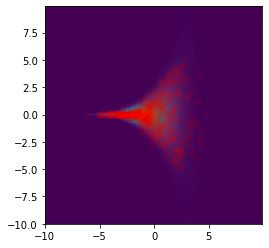

In [115]:
%matplotlib inline

def show(GeN,n,alpha=0.01):
    
    Z=GeN(n).detach().clone().cpu()
    plt.pcolormesh(grid_x.cpu().numpy(),grid_y.cpu().numpy(),p.exp().cpu().numpy())
    plt.scatter(Z[:,0],Z[:,1],color='red',alpha=alpha) 
    plt.axis('scaled')
    
    plt.draw()
    plt.show()
    
show(GeN,1000, 0.05)







In [116]:
from Inference.GeNVI_method import KDE


%matplotlib notebook

x=y=torch.arange(-2.,2.,0.02)
grid_x, grid_y = torch.meshgrid(x, y)
q=torch.Tensor(grid_x.shape)

Z=GeN.sample(1000).detach()

for i in range(q.shape[0]):
    for j in range(q.shape[1]):
        #x=torch.Tensor([grid_x[i,j],grid_y[i,j]]).unsqueeze(0)
        q[i,j]=KDE(torch.cat([grid_x[i,j].unsqueeze(0),grid_y[i,j].unsqueeze(0)]).unsqueeze(0),Z,device).squeeze(-1)


RuntimeError: expected device cuda:0 but got device cpu

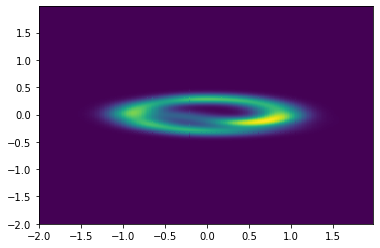

In [14]:
%matplotlib inline

plt.pcolormesh(grid_x.numpy(),grid_y.numpy(),q.exp().numpy())
plt.show()

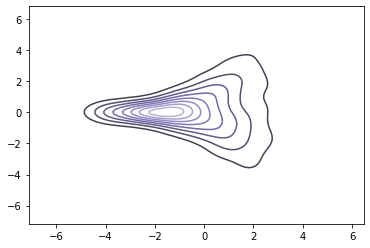

In [117]:
%matplotlib inline 
import seaborn as sns

sample=GeN(1000).detach().cpu().numpy()

sns.kdeplot(sample[:,0],sample[:,1], cmap="Purples_d")
